## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
from deep_translator import GoogleTranslator
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [2]:
train = pd.read_csv('labeled.csv', sep=';')
test = pd.read_csv('unlabeled.csv', sep=';')
augmented_df = pd.read_csv('augmented.csv')

train

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik
...,...,...
4995,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,Politik
4996,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,Politik
4997,imo both are irrational but yg satu jauh lebih...,Ekonomi
4998,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,Pertahanan dan Keamanan


<AxesSubplot: >

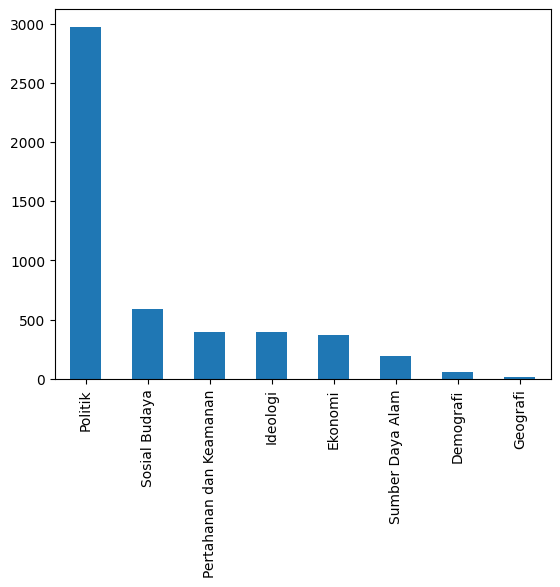

In [3]:
train['label'].value_counts().plot(kind='bar')

In [4]:
train.isnull().sum()

text     0
label    0
dtype: int64

In [5]:
test.isnull().sum()

IDText    0
Text      0
dtype: int64

In [6]:
test.duplicated().sum()

0

In [7]:
train.duplicated().sum()

381

## Data Preprocessing

### Data Cleaning

In [8]:
train.drop_duplicates(inplace=True)

In [10]:
def remove_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Expanded dictionary of abbreviations and their full forms
abbreviations_dict = {
    "skrg": "sekarang",
    "yg": "yang",
    "gk": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "engga": "tidak",
    "tdk": "tidak",
    "krn": "karena",
    "dgn": "dengan",
    "bgmn": "bagaimana",
    "blm": "belum",
    "kpn": "kapan",
    "pdhl": "padahal",
    "dr": "dari",
    "utk": "untuk",
    "tp": "tapi",
    "kl": "kalau",
    "klo": "kalau",
    "dlm": "dalam",
    "sdh": "sudah",
    "udh": "sudah",
    "jd": "jadi",
    "trs": "terus",
    "tmn": "teman",
    "msh": "masih",
    "bkn": "bukan",
    "sm": "sama",
    "sbg": "sebagai",
    "bbrp": "beberapa",
    "ank": "anak",
    "org": "orang",
    "thn": "tahun",
    "mrk": "mereka",
    "sy": "saya",
    "gw": "saya",
    "aku": "saya",
    "u": "kamu",
    "anda": "kamu",
    "km": "kamu",
    "dl": "dulu",
    "lh": "lah",
    "jg": "juga",
    "mn": "mana",
    "pr": "pekerjaan rumah",
    "dtg": "datang",
    "blg": "bilang",
    "sb": "sebab",
    "kt": "kata",
    "kpd": "kepada",
    "tsb": "tersebut",
    "dsb": "dan sebagainya",
    "dll": "dan lain-lain",
    "M3nang": "menang",
    "m3nang": "menang",
    "tbh": "to be honest",
    "kudu": "harus",
    "bgt": "banget",
    "bngt": "banget",
    "bgtu": "begitu",
    "bgtt": "banget",
    "lgislatif": "legislatif",
    "ae": "saja",
    "bkn": "bukan",
    "bknnya": "bukannya",
    "bknnya": "bukannya",
    "ajh": "saja",
    "aj": "saja",
    "ajah": "saja",
    "mngmcam": "mengancam",
    "bhkn": "bahkan",
    "emng": "emang",
    "memang": "emang",
    "lu": "kamu",
    "lo": "kamu",
    "brani": "berani",
    "brni": "berani",
    "brrti": "berarti",
    "brarti": "berarti",
    "bener": "benar",
    
}


def preprocess_text(text):

    # Remove RT (retweet) from the beginning of the text
    text = re.sub(r'^RT', '', text)

    # Remove RT followed by a Twitter handle
    text = re.sub(r'RT\s@\S+', '', text)
    
    # Remove Twitter handles (handles not prefixed by RT)
    text = re.sub(r'@\S+', '', text)
    
    # Remove HMTL tags
    text = remove_tags(text)

    # Convert to lowercase
    text = text.lower()

    # remove Hashtags
    text = re.sub(r'#\S+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove content in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) 
    
    # Remove special characters and unnecessary symbols
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # # Replace abbreviations based on the dictionary
    for abbr, full in abbreviations_dict.items():
        text = re.sub(r'\b' + abbr + r'\b', full, text)

    # Define Indonesian negative words
    negative_words = ['tidak', 'tak', 'bukan', 'belum', 'jangan', 'kurang']

    # Remove Stopwords (Indonesian)
    indonesian_stopwords = stopwords.words('indonesian')
    stopwords_without_negatives = [word for word in indonesian_stopwords if word not in negative_words]
    
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_without_negatives) + r')\b\s*')
    text = pattern.sub('', text)

    text = stemmer.stem(text)
    return text

    
    return text


In [11]:
train['text'] = train['text'].apply(preprocess_text)
test['Text'] = test['Text'].apply(preprocess_text)
train

,text,label
0,kunjung prabowo resmi serah proyek bantu air b...,Sumber Daya Alam
1,anies tepuk tangan riah rektor wajib mata kuli...,Politik
2,emang sih dukung goblok dg dukung hnya sj ridw...,Demografi
3,anies sikap kritis kerja prabowo anggap tidak ...,Politik
4,anies baswedan harap asn tni polri pegang sump...,Politik
...,...,...
4995,ngeliat debat kemaren pas prabowo kicep kira k...,Politik
4996,masyarakat prabowo gibran milik visi jalan asp...,Politik
4997,imo both are irrational but irrational to be h...,Ekonomi
4998,look at that ganjar kecimpung legislatif eksek...,Pertahanan dan Keamanan


In [ ]:
test

### Translate to the same language

In [11]:
# # translate function to indonesia
# def translate_to_indonesia(text):
#     translated = GoogleTranslator(source='en', target='id').translate(text)
#     return translated

In [12]:
# train['text'] = train['text'].apply(translate_to_indonesia)
# train

In [13]:
# test['Text'] = test['Text'].apply(translate_to_indonesia)
# test

### Encode Label

In [12]:
train['label'].value_counts()


Politik                    2972
Sosial Budaya               425
Ideologi                    343
Pertahanan dan Keamanan     331
Ekonomi                     310
Sumber Daya Alam            157
Demografi                    61
Geografi                     20
Name: label, dtype: int64

In [13]:
train['label'] = train['label'].map({'Politik':0, 'Sosial Budaya':1, 'Pertahanan dan Keamanan':2, 'Ideologi':3, 'Ekonomi':4, 'Sumber Daya Alam':5, 'Demografi':6, 'Geografi': 7})
train

,text,label
0,kunjung prabowo resmi serah proyek bantu air b...,5
1,anies tepuk tangan riah rektor wajib mata kuli...,0
2,emang sih dukung goblok dg dukung hnya sj ridw...,6
3,anies sikap kritis kerja prabowo anggap tidak ...,0
4,anies baswedan harap asn tni polri pegang sump...,0
...,...,...
4995,ngeliat debat kemaren pas prabowo kicep kira k...,0
4996,masyarakat prabowo gibran milik visi jalan asp...,0
4997,imo both are irrational but irrational to be h...,4
4998,look at that ganjar kecimpung legislatif eksek...,2


In [14]:
train['label'].value_counts()

0    2972
1     425
3     343
2     331
4     310
5     157
6      61
7      20
Name: label, dtype: int64

### Vectorizer

In [15]:
# Memisahkan fitur (X) dan label (y)
X = train['text']
y = train['label']

# Memisahkan data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Modelling

### Cross-Validation

### Modelling

In [17]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Menginisialisasi model XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Melatih model
model.fit(X_train_vectorized, y_train)

c:\Users\Naufalqii\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [18]:
# Memprediksi pada data uji
y_pred = model.predict(X_test_vectorized)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy:.4f}')


Akurasi: 0.7294


In [19]:
from sklearn.metrics import balanced_accuracy_score


In [20]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')

Balanced Accuracy: 0.3821


In [22]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, balanced_accuracy_score

# Menginisialisasi K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menggunakan balanced accuracy sebagai metrik
scorer = make_scorer(balanced_accuracy_score)

# Melakukan cross-validation
cv_results = cross_val_score(model, X_train_vectorized, y_train, cv=kf, scoring=scorer)

# Menampilkan hasil cross-validation
print(f'Balanced Accuracy per fold: {cv_results}')
print(f'Average Balanced Accuracy: {cv_results.mean():.4f}')

c:\Users\Naufalqii\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Naufalqii\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Naufalqii\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Naufalqii\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Naufalqii\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarnin

Balanced Accuracy per fold: [0.33500883 0.3680491  0.40991919 0.35349378 0.34514859]
Average Balanced Accuracy: 0.3623
